In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)


In [ ]:
def load_my_dataset():
    X_train = pd.read_csv("/content/data/processed/X_train_res.csv")
    X_test = pd.read_csv("/content/data/processed/X_test.csv")
    y_train = pd.read_csv("/content/data/processed/y_train_res.csv").squeeze()  # Converts DataFrame to Series
    y_test = pd.read_csv("/content/data/processed/y_test.csv").squeeze()

    print("Dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "My Dataset"

# Test loading
X_train, X_test, y_train, y_test, _ = load_my_dataset()


Dataset loaded successfully.
Training set shape: (3978, 21)
Testing set shape: (426, 21)


In [ ]:
param_grid_dt = {
    'selectkbest__k': [5, 10, 15, 'all'],
    'classifier__max_depth': [None, 3, 5, 8],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'selectkbest__k': [5, 10, 15, 'all'],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

param_grid_lr = {
    'selectkbest__k': [5, 10, 15, 'all'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__max_iter': [500]
}

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'kNN'),
    (LogisticRegression(random_state=42), param_grid_lr, 'Logistic Regression')
]


In [ ]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    print(f"\nBuilt-in GridSearchCV for {dataset_name}")
    best_estimators = {}
    n_features = X_train.shape[1]

    for clf, param_grid, name in classifiers_to_tune:
        print(f"\nRunning GridSearchCV ...")
        adjusted_grid = {}
        for k, v in param_grid.items():
            if k.startswith('selectkbest__k'):
                adjusted_grid[k] = [vv if vv=='all' or vv<=n_features else n_features for vv in v]
            else:
                adjusted_grid[k] = v

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selectkbest', SelectKBest(f_classif)),
            ('classifier', clf)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_grid,
            cv=cv_splitter,
            scoring='accuracy',  # safer for multiclass
            n_jobs=-1,
            refit=True
        )
        grid.fit(X_train, y_train)
        print(f"{name} best params: {grid.best_params_}, CV Accuracy: {grid.best_score_:.4f}")
        best_estimators[name] = grid.best_estimator_

    return best_estimators

best_estimators = run_builtin_grid_search(X_train, y_train, "My Dataset")



Built-in GridSearchCV for My Dataset

Running GridSearchCV ...
Decision Tree best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'selectkbest__k': 15}, CV Accuracy: 0.9641

Running GridSearchCV ...
kNN best params: {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance', 'selectkbest__k': 15}, CV Accuracy: 0.9721

Running GridSearchCV ...
Logistic Regression best params: {'classifier__C': 1, 'classifier__max_iter': 500, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'selectkbest__k': 'all'}, CV Accuracy: 0.8851


# Evaluating Models

1. Decision Tree
2. kNN
3. Logistic Regression


In [ ]:
def evaluate_models_multiclass(X_train, y_train, X_test, y_test, best_estimators, dataset_name):
    print(f"\nEvaluating models for {dataset_name}")
    lb = LabelBinarizer()

    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        print(f"\n{name} Metrics:")

        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.4f}")
        print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.4f}")
        print(f"F1-score: {f1_score(y_test, y_pred, average='macro'):.4f}")

        # ROC AUC for multiclass
        y_test_bin = lb.fit_transform(y_test)
        auc_score = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
        print(f"ROC AUC: {auc_score:.4f}")



evaluate_models_multiclass(X_train, y_train, X_test, y_test, best_estimators, "My Dataset")



Evaluating models for My Dataset

Decision Tree Metrics:
Accuracy: 0.9155
Precision: 0.8828
Recall: 0.8609
F1-score: 0.8692
ROC AUC: 0.8930

kNN Metrics:
Accuracy: 0.9085
Precision: 0.8400
Recall: 0.8718
F1-score: 0.8512
ROC AUC: 0.9338

Logistic Regression Metrics:
Accuracy: 0.8779
Precision: 0.7637
Recall: 0.8471
F1-score: 0.7933
ROC AUC: 0.9698


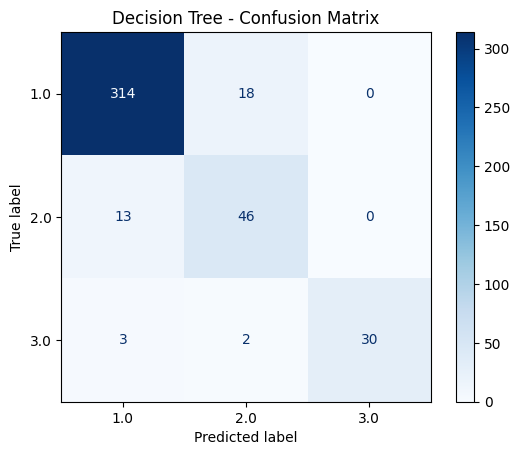

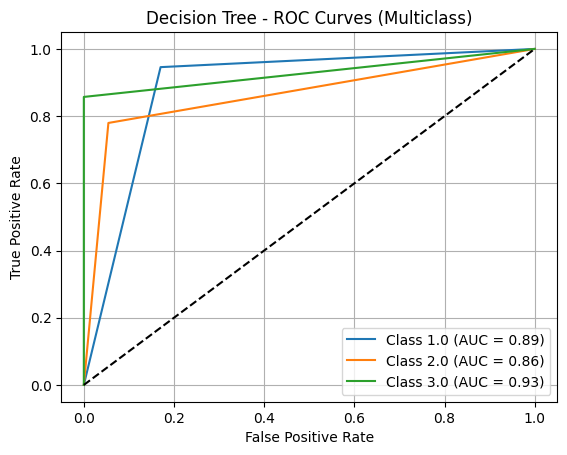

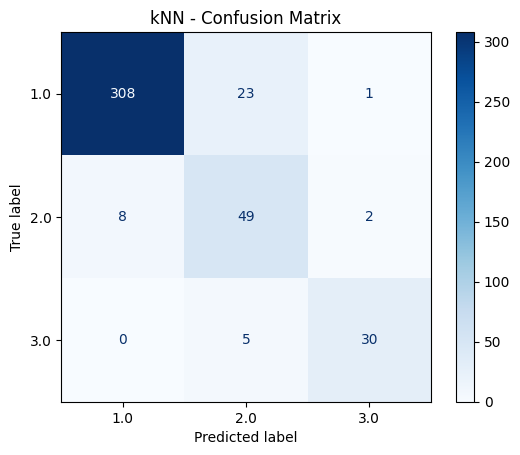

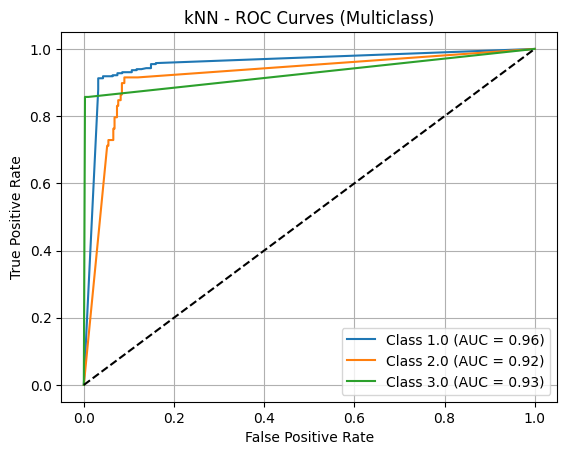

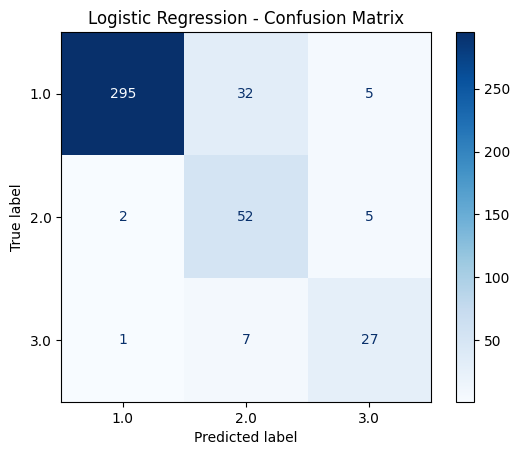

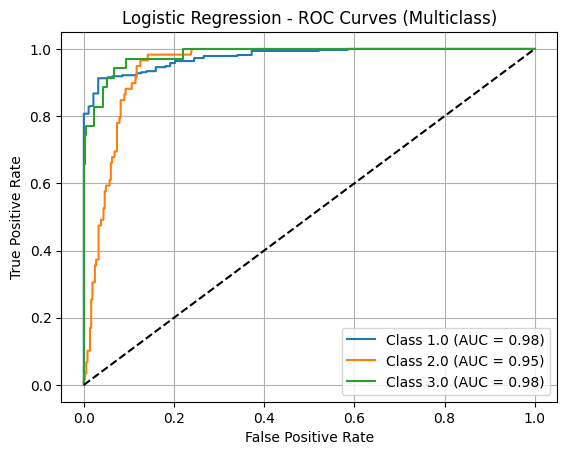

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_evaluations(X_test, y_test, best_estimators):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    n_classes = len(lb.classes_)

    for name, model in best_estimators.items():
        y_prob = model.predict_proba(X_test)
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f'{name} - Confusion Matrix')
        plt.show()

        # ROC Curves for each class
        fpr = {}
        tpr = {}
        roc_auc = {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{name} - ROC Curves (Multiclass)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

plot_multiclass_evaluations(X_test, y_test, best_estimators)
